# Sydney AirBnB Homes Analysis

The following code considers the AirBnB dataset of Sydney and finds answers to the following qiestions:
1. Given your budget, where to look for an Airbnb home?
2. What time of the year is the cheapest to visit Sydney? 
3. Using the information provided in a listing, can we predict its price?


## Importing libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from numpy import arange


import geopandas as gpd
from geopandas import GeoDataFrame
import gmplot
import warnings
warnings.filterwarnings('ignore')

# Question 1: Given your budget, where to look for an Airbnb home?

Read the dataset

In [2]:
listings = pd.read_csv('sydney_abnb_data/listings.csv')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20210908154535,2021-09-09,An Oasis in the City,Very central to the city which can be reached ...,"It is very close to everything and everywhere,...",https://a0.muscache.com/pictures/2797669/17895...,40855,https://www.airbnb.com/users/show/40855,...,4.77,4.82,4.71,NaN,f,1,0,1,0,2.06
1,12351,https://www.airbnb.com/rooms/12351,20210908154535,2021-09-09,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"Pyrmont is an inner-city village of Sydney, on...",https://a0.muscache.com/pictures/763ad5c8-c951...,17061,https://www.airbnb.com/users/show/17061,...,4.91,4.92,4.81,NaN,f,2,0,2,0,4.40
2,14250,https://www.airbnb.com/rooms/14250,20210908154535,2021-09-09,Manly Harbour House,"Beautifully renovated, spacious and quiet, our...",Balgowlah Heights is one of the most prestigio...,https://a0.muscache.com/pictures/56935671/fdb8...,55948,https://www.airbnb.com/users/show/55948,...,4.33,4.67,4.33,NaN,f,2,2,0,0,0.04
3,15253,https://www.airbnb.com/rooms/15253,20210908154535,2021-09-09,Unique Designer Rooftop Apartment in City Loca...,Penthouse living at it best ... You will be st...,The location is really central and there is nu...,https://a0.muscache.com/pictures/46dcb8a1-5d5b...,59850,https://www.airbnb.com/users/show/59850,...,4.67,4.70,4.47,NaN,t,1,0,1,0,3.60
4,44545,https://www.airbnb.com/rooms/44545,20210908154535,2021-09-09,Sunny Darlinghurst Warehouse Apartment,Sunny warehouse/loft apartment in the heart of...,Darlinghurst is home to some of Sydney's best ...,https://a0.muscache.com/pictures/a88d8e14-4f63...,112237,https://www.airbnb.com/users/show/112237,...,4.96,4.93,4.77,NaN,f,1,1,0,0,1.03


First lets have a look at the distribution of listings based on the number of guests they can accommodate. 

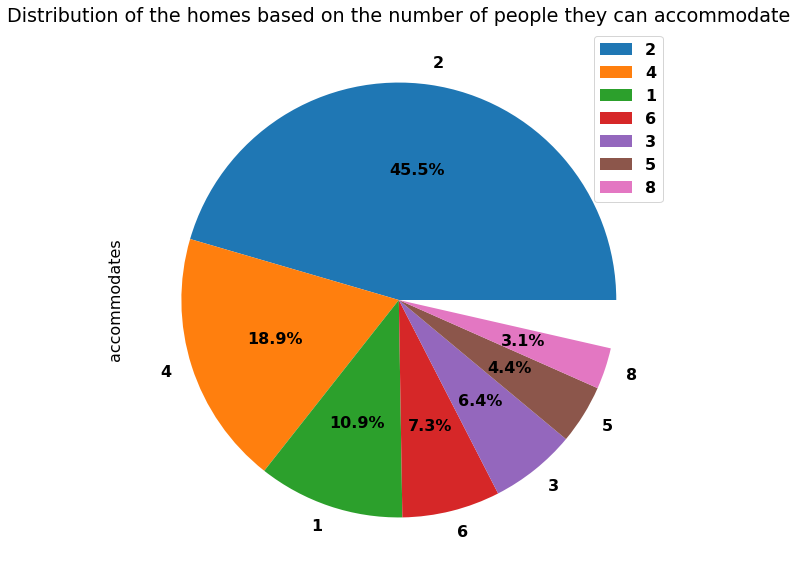

In [39]:
value_count_accommodates = listings.accommodates.value_counts()
(value_count_accommodates[:7]/listings.shape[0]).plot(kind='pie', title='Distribution of the homes based on the number of people they can accommodate',
                                xlabel='Number of guests', figsize=(15,10), legend=True, autopct='%1.1f%%');
plt.savefig('pie_chart_price_dist.jpg', dpi=500)

In [5]:
(value_count_accommodates[:7]/listings.shape[0])

2    0.444054
4    0.183113
1    0.116984
6    0.072801
3    0.062295
5    0.042572
8    0.035997
Name: accommodates, dtype: float64

categorise the listings based on the maximum number of guests and generate a heatmap using gmplot library for each category. Each point on the map shows an Airbib listing and its color reflect the price. More reddish color represents more expensive listings.  

In [4]:
# the following function is a modified version of the one presented in the following link: 
# https://betterprogramming.pub/build-a-user-defined-function-to-return-a-color-based-on-a-value-and-range-1f4838b29b2d
def hexcolor(value, range, reverse=False):
    min = range[0]
    max = range[1]
    if value > max: value = max
    if value < min: value = min
    if value <= int((min+max)/2):
        r = 255
        g = int(255*value/int((min+max)/2))
        b = 0
    else:
        r = int(255*(max-value)/int((min+max)/2))
        g = 255
        b = 0
    if reverse:
        r, g = g, r
    return "#%s%s%s" % tuple([hex(c)[2:].rjust(2, "0") for c in (r, g, b)])

# Preprocessing 'price' column
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype(float)

# Remove Outliers from the 'price' column
price_low = listings['price'].quantile(0.02)
price_hi = listings['price'].quantile(0.98)

listings = listings[(listings['price'] < price_hi) & (listings['price'] > price_low)]

for num_acco in value_count_accommodates.index:
    tmp_df = listings[listings['accommodates'] == num_acco]
    color = [hexcolor(value=list(tmp_df.price)[i], range=[tmp_df.price.quantile(0.1), tmp_df.price.quantile(0.9)], reverse=True) for i in range(len(list(tmp_df.price)))]

    gmap = gmplot.GoogleMapPlotter
    gmap4 = gmplot.GoogleMapPlotter.from_geocode("Sudney, Australia", apikey='************')
    gmap4.scatter(tmp_df.latitude, tmp_df.longitude, color=color,
                  size=40, marker=False)
    gmap4.draw('listings_with_{}_number_of_guests.html'.format(num_acco))



Show a map generated for the listings that can accommodate up to 2 guests. 

In [5]:
from IPython.display import IFrame
IFrame(src='listings_with_2_number_of_guests.html', width=900, height=600)

## Question 2: The cheapest time to visit Sydney

Read the calendar dataset. 

In [6]:
calander = pd.read_csv('sydney_abnb_data/calendar.csv')
calander.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,44545,2021-09-09,f,$130.00,$130.00,3.0,365.0
1,15253,2021-09-09,t,$79.00,$79.00,2.0,90.0
2,15253,2021-09-10,t,$79.00,$79.00,2.0,90.0
3,15253,2021-09-11,t,$79.00,$79.00,2.0,90.0
4,15253,2021-09-12,t,$79.00,$79.00,2.0,90.0


change the date column to datetime, extract the month from date and add it to a newly created 'month' column.

In [7]:
calander['date'] = pd.to_datetime(calander['date'])
calander['month'] = pd.DatetimeIndex(calander['date']).month

preprocess the 'price' column

In [8]:
calander['price'] = calander['price'].str.replace('$', '')
calander['price'] = calander['price'].str.replace(',', '')
calander['price'] = calander['price'].astype(float)

Drop nan from price column and sort the dataframe based on 'month' column

In [9]:
calander.dropna(subset=['price'],inplace=True)
calander.sort_values(by=['month'],inplace=True)
calander.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,month
2509746,13325233,2022-01-28,f,120.0,$120.00,2.0,1125.0,1
3476223,17079448,2022-01-13,f,60.0,$60.00,2.0,21.0,1
3476224,17079448,2022-01-14,f,60.0,$60.00,2.0,21.0,1
3476225,17079448,2022-01-15,f,60.0,$60.00,2.0,21.0,1
3476226,17079448,2022-01-16,f,60.0,$60.00,2.0,21.0,1


Plot the average price for each month of the year provide a background color representing the season of the year. 

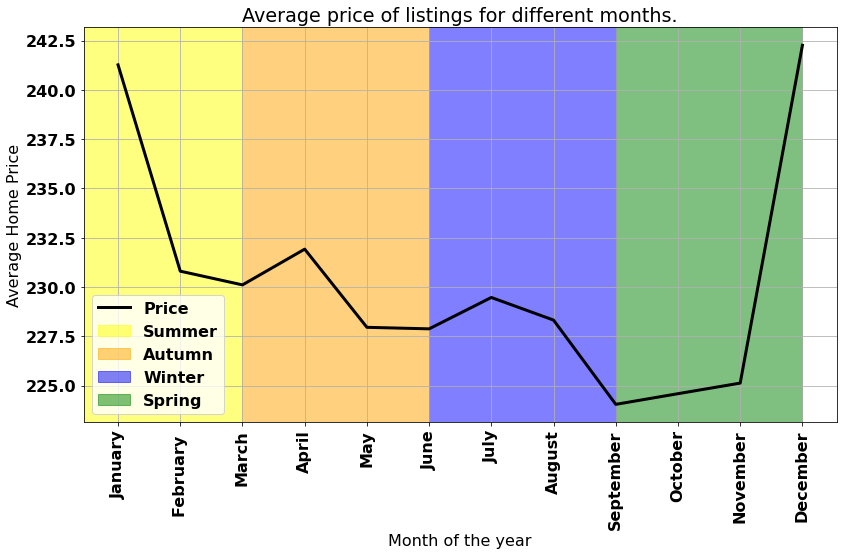

In [17]:
from matplotlib.patches import Rectangle
ax = calander.groupby(by=['month']).mean()['price'].plot(kind='line',figsize=(12,8),
                                                    title='Average price of listings for different months.',
                                                    ylabel='Average Home Price', xlabel='Month of the year', linewidth=3,
                                                    xticks=range(1,13), color='black', grid=True, rot=90);
ax.set_xticklabels(['January','February ','March','April','May','June',
                    'July','August','September','October','November', 'December']);

summer = Rectangle((0,0), 3, 500, fill=True, color='yellow',alpha=0.5)

ax.add_patch(summer)

fall = Rectangle((3,0), 3, 500, fill=True, color='orange',alpha=0.5)

ax.add_patch(fall)

winter = Rectangle((6,0), 3, 500, fill=True, color='blue',alpha=0.5)

ax.add_patch(winter)

spring = Rectangle((9,0), 3, 500, fill=True, color='green',alpha=0.5)

ax.add_patch(spring)

ax.legend(['Price','Summer', 'Autumn', 'Winter', 'Spring'])
plt.tight_layout()
plt.savefig('seasonal_price.jpg', dpi=500)


In [18]:
calander['dayofyear'] = pd.DatetimeIndex(calander['date']).dayofyear
calander.sort_values(by=['dayofyear'],inplace=True)
calander.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,month,dayofyear
8299740,37099290,2022-01-01,f,38.0,$38.00,1.0,13.0,1,1
4832784,21871354,2022-01-01,f,150.0,$150.00,5.0,15.0,1,1
9239724,40512567,2022-01-01,f,250.0,$250.00,3.0,1125.0,1,1
7803472,34319284,2022-01-01,f,300.0,$300.00,2.0,30.0,1,1
8735045,39214348,2022-01-01,f,90.0,$90.00,2.0,1125.0,1,1


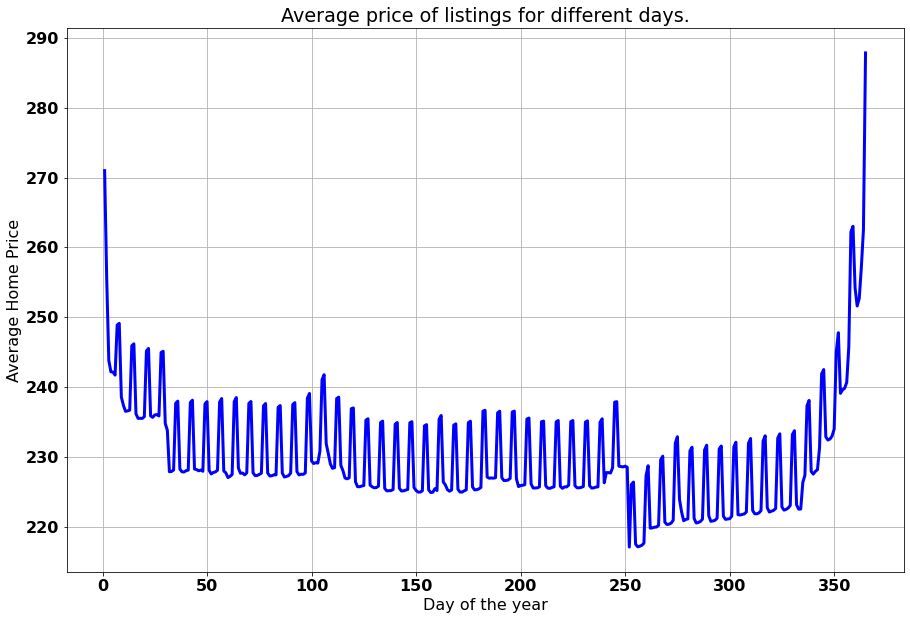

In [20]:

ax = calander.groupby(by=['dayofyear']).mean()['price'].plot(kind='line',figsize=(15,10),
                                                    title='Average price of listings for different days.',
                                                    ylabel='Average Home Price', xlabel='Day of the year', linewidth=3,
                                                    color='blue', grid=True);
plt.savefig('daily_price.jpg', dpi=500)

## Question 3: Using the information provided in a listing, can we predict its price?

Load the dataset and perform some data wrangling. 

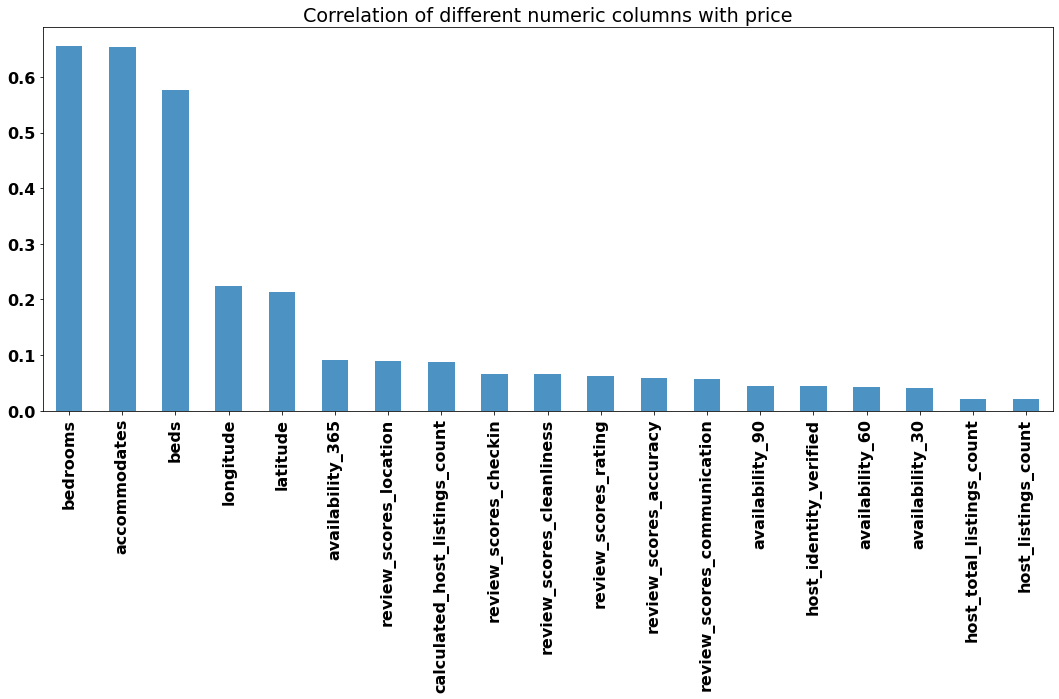

In [24]:
listings = pd.read_csv('sydney_abnb_data/listings.csv')
listings['longitude'].isna().sum()
# Preprocessing 'price' column
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype(float)

# Remove Outliers from the 'price' column
price_low = listings['price'].quantile(0.02)
price_hi = listings['price'].quantile(0.98)
listings = listings[(listings['price'] < price_hi) & (listings['price'] > price_low)]

# Preprocessing 'host_response_rate' column
listings['host_response_rate'] = listings['host_response_rate'].str.replace('%', '')
listings['host_response_rate'] = listings['host_response_rate'].astype(float)

# Preprocessing 'host_acceptance_rate' column
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace('%', '')
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].astype(float)

# Preprocessing 'host_is_superhost' column
listings['host_is_superhost'].replace('f', False, inplace=True)
listings['host_is_superhost'].replace('t', True, inplace=True)
listings['host_is_superhost'] = listings['host_is_superhost'].astype(bool)

# Preprocessing 'host_identity_verified' column
listings['host_identity_verified'].replace('f', False, inplace=True)
listings['host_identity_verified'].replace('t', True, inplace=True)
listings['host_identity_verified'] = listings['host_identity_verified'].astype(bool)

# Preprocessing 'has_availability' column
listings['has_availability'].replace('f', False, inplace=True)
listings['has_availability'].replace('t', True, inplace=True)
listings['has_availability'] = listings['has_availability'].astype(bool)

# Preprocessing 'instant_bookable' column
listings['instant_bookable'].replace('f', False, inplace=True)
listings['instant_bookable'].replace('t', True, inplace=True)
listings['instant_bookable'] = listings['instant_bookable'].astype(bool)


# Preprocessing 'host_has_profile_pic' column
listings['host_has_profile_pic'].replace('f', False, inplace=True)
listings['host_has_profile_pic'].replace('t', True, inplace=True)
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].astype(bool)

#remove irrelevant columns
columns_to_remove = ['id', 'host_id', 'host_name','neighbourhood', 'listing_url', 'scrape_id', 'last_scraped', 
                     'picture_url', 'host_url', 'host_location', 'host_thumbnail_url', 'host_picture_url', 
                     'host_neighbourhood', 'neighbourhood', 'neighbourhood_group_cleansed',
                     'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                     'calendar_updated', 'calendar_last_scraped', 'license',  
                     'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_shared_rooms']
listings.drop(columns=columns_to_remove, inplace=True)

# drop columns with more than 90% nan
listings.drop(columns=listings.columns[(listings.isna()).mean() > 0.9], inplace=True)

#calculate correlation for price culumn 
price_correlation = listings.corr()['price'].sort_values(ascending = False).head(20)[1:]
price_correlation

price_correlation.plot(kind = 'bar', 
                       title='Correlation of different numeric columns with price',
                       figsize=(15,10), alpha=0.8);
plt.tight_layout()
plt.savefig('correlation_price.jpg', dpi=500)


As expected, the number of bedrooms and maximum number of guests are the two most important factors affecting the price. Location (represented by latiture and longtitude) looks to influece the price as well. As a first step, lets check the performance of a linear regressor only using numerical columns. Before that lets have a look at the price distribution. 

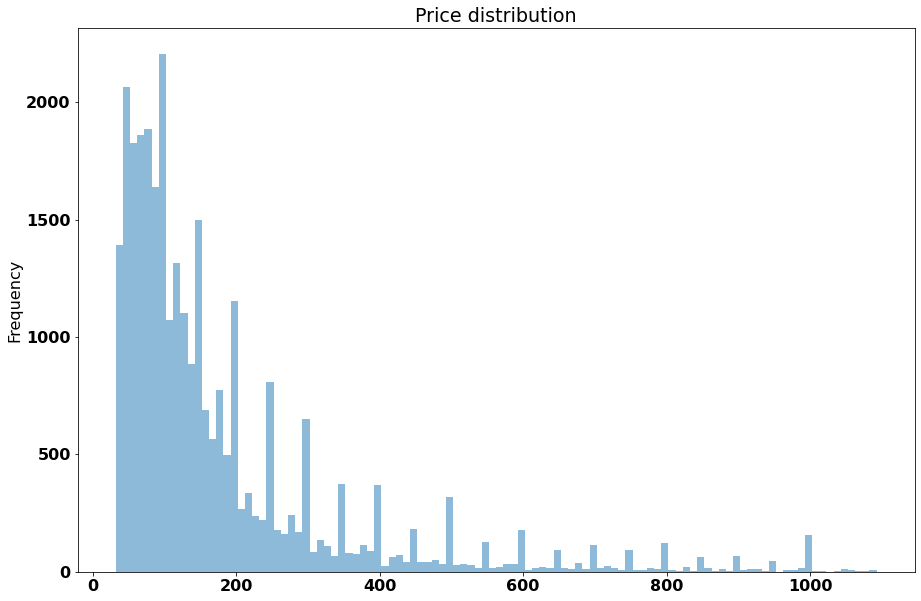

In [74]:
listings['price'].plot.hist(bins=int((listings['price'].max() - listings['price'].min())/10),
                           figsize=(15,10), alpha=0.5, title='Price distribution', xlabel='Price');

That is interesting to see how hosts tend to use multiples of 50 as the price of their listing.  

In [25]:
def clean_data(df, columns_index):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no price
    2. Create X as all the columns that are in columns_index
    3. Create y as the price column
    4. For each numeric variable in X, fill the column with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    
    # exclude columns which are not in columns_index
    df = df[columns_index].drop(['price'],axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y



As a first step, lets see how the prediction goes with selecting only numerical columns as features for the linear regression model. 

In [26]:
# select only numerical columns
num_vars = listings.select_dtypes(include=['float', 'int']).columns
X, y = clean_data(listings, columns_index=num_vars)

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=50)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#check r2_score for training and test sets
print('The r2_score for test data is:', r2_score(y_test, y_test_preds))
print('The r2_score for training data is:', r2_score(y_train, y_train_preds))

#check RMSE for training and test sets
print('The RMSE for test data is:', mean_squared_error(y_test, y_test_preds, squared=False))
print('The RMSE for training data is:', mean_squared_error(y_train, y_train_preds, squared=False))


The r2_score for test data is: 0.5272915893177632
The r2_score for training data is: 0.5257046999220181
The RMSE for test data is: 118.6938091741607
The RMSE for training data is: 119.1918559961095


Only using relevant numeric columnns we get a test r2_score of 0.527. Not too bad. Lets see if we can improve this results. We can improve the results by adding some categorical and boolean columns or by using a better regression technique such as xgboost, random forest, and neural network.  

By looking at the data and using some common sense, we expect that columns such as 'host_is_superhost' or 'host_identity_verified' should play a role in defining the price. I personally would ignore those host with their identity not verified. 

Lets have a look at object columns. To see whcih ones should be added to the numeric columns. 

In [27]:
obj_vars = listings.select_dtypes(include=['object']).columns
obj_vars

Index(['name', 'description', 'neighborhood_overview', 'host_since',
       'host_about', 'host_response_time', 'host_verifications',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'first_review', 'last_review'],
      dtype='object')

From the list of categorical columns, we add ['host_response_time', 'host_verifications',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text'] along with boolean columns to the data used for regression. Let's check the performace of the linear model after adding those columns.  

In [28]:
selected_obj_columns = ['host_response_time', 'host_verifications', 'neighbourhood_cleansed', 
                        'property_type', 'room_type', 'bathrooms_text']
bool_vars = listings.select_dtypes(include=['bool']).columns
final_list_of_columns = list(num_vars) + list(bool_vars) + selected_obj_columns

X, y = clean_data(listings, columns_index=final_list_of_columns)

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=50)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
# lm_model = LassoCV()
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#check r2_score for training and test sets
print('The r2_score for test data is:', r2_score(y_test, y_test_preds))
print('The r2_score for training data is:', r2_score(y_train, y_train_preds))

#check RMSE for training and test sets
print('The RMSE for test data is:', mean_squared_error(y_test, y_test_preds, squared=False))
print('The RMSE for training data is:', mean_squared_error(y_train, y_train_preds, squared=False))


The r2_score for test data is: -9.086527659686475e+26
The r2_score for training data is: 0.6126308870329165
The RMSE for test data is: 5203917217604239.0
The RMSE for training data is: 107.71710341773048


Oops, it looks like the linear model is doing something strange after including the new columns to the data. Maybe we should select a subset of features to improve the results. We use the following function which is a modified version of the one used in udacity data science nanodegree. 

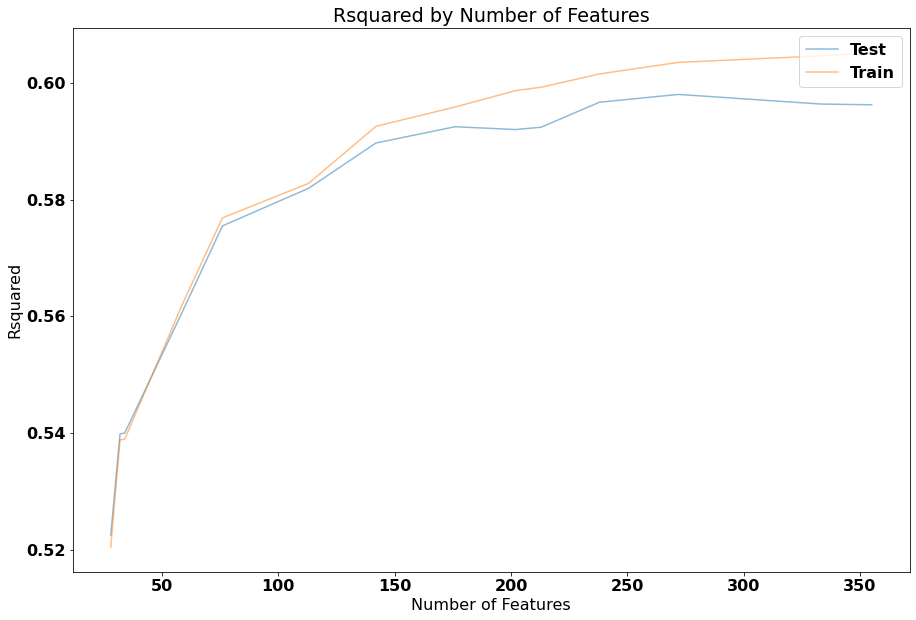

The r2_score for the test data 0.5980523817576161
The RMSE for test data is: 109.45009242326344
The best r2_score for the test data is 0.5980523817576161 and its corresponding training r2_score is 0.6035489168665557


In [29]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=50, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.figure(figsize=(15,10))
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    print('The r2_score for the test data',r2_score(y_test, y_test_preds))
    print('The RMSE for test data is:', mean_squared_error(y_test, y_test_preds, squared=False))

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [15000, 10000, 5000, 1000, 500,200, 100, 50, 30, 25, 15, 10, 4, 3]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)
print(f'The best r2_score for the test data is {max(r2_scores_test)} and its corresponding training r2_score is {r2_scores_train[np.argmax(r2_scores_test)]}')


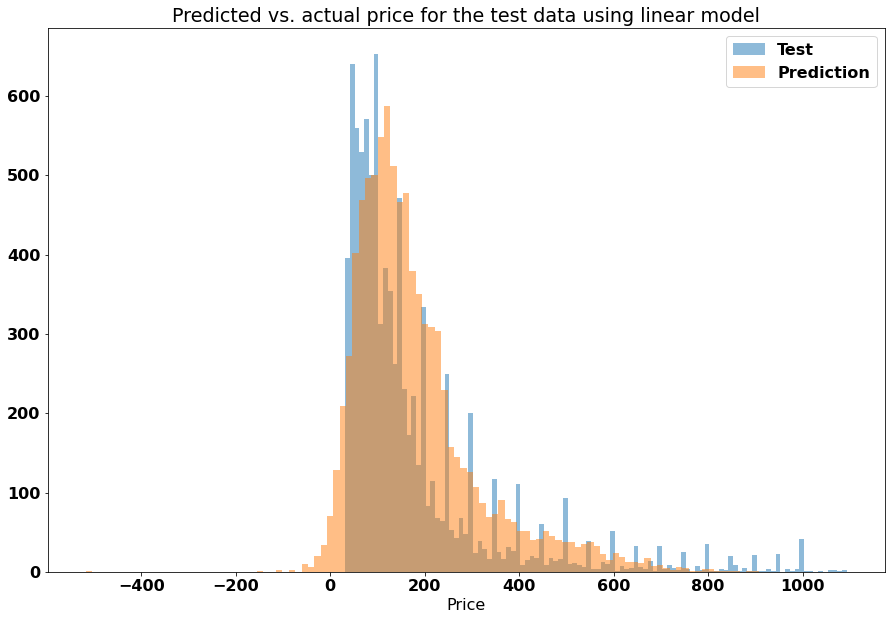

In [31]:
plt.figure(figsize=(15, 10))
plt.hist(y_test, bins=int((listings['price'].max() - listings['price'].min())/10), alpha=0.5)
plt.hist(lm_model.predict(X_test), bins=int((listings['price'].max() - listings['price'].min())/10), alpha=0.5)
plt.legend(['Test', 'Prediction'])
plt.xlabel('Price')
plt.title('Predicted vs. actual price for the test data using linear model')
plt.savefig('lm_pred_test_hist.jpg', dpi=500)
plt.show()

Well, now that we know what the issue was, we can try more sophisticated regression techniques to check if we can further improve the performance. Let's do it in a systematic way by writing a function. 

In [32]:
# the following set of commands removes characters '[', ']', and '>' from the column names. 
# It seems xgboost does not like those characters in the column names. 
X.columns = [label.replace(' ', '_') for label in X.columns]
X.columns = [label.replace('[', '_') for label in X.columns]
X.columns = [label.replace(']', '_') for label in X.columns]
X.columns = [label.replace('>', '_') for label in X.columns]

In [87]:
def simulate_model(model, model_name, X, y, test_size = .30, random_state=50):
    '''
    This function simulates a model (linear, random forest, xgboost, Lasso, etc. and check the performance)
    by computing r2 scores
    
    INPUT
    model - the model using which regression problem is solved
    model_name - the name of the model, used for printing
    X - dataframe containing the features
    y - dataframe containing the response
    test_size - size of the test set
    random_state - seed used for splitting the data into training and test

    OUTPUT
    r2_scores_test - r2 scores of the test data generated using model
    r2_scores_train - r2 scores of the training data generated using model
    '''
    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)

    #fit the model and obtain pred response
    model.fit(X_train, y_train)
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)

    #append the r2 value from the test set
    r2_scores_test = r2_score(y_test, y_test_preds)
    r2_scores_train = r2_score(y_train, y_train_preds)
    
    print(f'Using {model_name}, the best r2_score for the test data is {r2_scores_test} and its corresponding training r2_score is {r2_scores_train}')
    print(f'Using {model_name}, the best RSME for the test data is {mean_squared_error(y_test, y_test_preds, squared=False)} and its corresponding training RSME is {mean_squared_error(y_train, y_train_preds, squared=False)}')
    
    return r2_scores_test, r2_scores_train
models = {'xgboost': XGBRegressor(), 
          'Random Forest': RandomForestRegressor(),
          'Lasso': Lasso(), 
          'LassoCV': LassoCV()}
for model_name, model in models.items():
    r2_scores_test, r2_scores_train = simulate_model(model, model_name, X, y)


Using xgboost, the best r2_score for the test data is 0.6560956325998322 and its corresponding training r2_score is 0.8350964614144558
Using xgboost, the best RSME for the test data is 101.23955986923531 and its corresponding training RSME is 70.28087492998507
Using Random Forest, the best r2_score for the test data is 0.6500156902526245 and its corresponding training r2_score is 0.9508348749208094
Using Random Forest, the best RSME for the test data is 102.13055459602704 and its corresponding training RSME is 38.37520832038404
Using Lasso, the best r2_score for the test data is 0.5541847688192332 and its corresponding training r2_score is 0.5552086066026678
Using Lasso, the best RSME for the test data is 115.26802547915766 and its corresponding training RSME is 115.42512657290692
Using LassoCV, the best r2_score for the test data is 0.5250122993019024 and its corresponding training r2_score is 0.526581226272551
Using LassoCV, the best RSME for the test data is 118.9796220289722 and it

It seems that XGBRegressor performs better than others. We are using its default options. How about trying to tune hyper parameters using RandomizedSearchCV method of sklearn package. Lets try!

In [20]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000, 1500]}
xgb_regg = XGBRegressor(seed = 50)
xgb_regg_search_cv = RandomizedSearchCV(estimator=xgb_regg,
                         param_distributions=params,
                         scoring='r2',
                         n_iter=50,
                         verbose=2,
                         cv=3)
xgb_regg_search_cv.fit(X, y)
print("Best parameters:", xgb_regg_search_cv.best_params_)
print("Highest r2_score: ", xgb_regg_search_cv.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, learning_rate=0.2, max_depth=20, n_estimators=100, subsample=0.7; total time=   7.9s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, learning_rate=0.2, max_depth=20, n_estimators=100, subsample=0.7; total time=   8.1s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, learning_rate=0.2, max_depth=20, n_estimators=100, subsample=0.7; total time=   7.9s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7999999999999999; total time=  13.9s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7999999999999999; total time=  13.9s
[CV] END colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.7999999999999999; total time=  13.9s
[CV] END colsampl

[CV] END colsample_bylevel=0.6, colsample_bytree=0.7999999999999999, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.7; total time=   7.2s
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.7, learning_rate=0.3, max_depth=20, n_estimators=1000, subsample=0.8999999999999999; total time= 1.3min
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.7, learning_rate=0.3, max_depth=20, n_estimators=1000, subsample=0.8999999999999999; total time= 1.2min
[CV] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.7, learning_rate=0.3, max_depth=20, n_estimators=1000, subsample=0.8999999999999999; total time= 1.2min
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7999999999999999; total time=  23.5s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7999999999999999; total time=  23.5

[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.3, max_depth=6, n_estimators=1500, subsample=0.6; total time= 1.0min
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.7999999999999999, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.7; total time=  25.5s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.7999999999999999, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.7; total time=  25.5s
[CV] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.7999999999999999, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.7; total time=  25.5s
[CV] END colsample_bylevel=0.7, colsample_bytree=0.4, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.6; total time=  26.9s
[CV] END colsample_bylevel=0.7, colsample_bytree=0.4, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.6; total time=  26.8s
[CV] END colsample_bylevel=0.7, colsample_bytree=0.4, learn

In [21]:
best_model = XGBRegressor(n_estimators=xgb_regg_search_cv.best_params_['n_estimators'],
                          subsample=xgb_regg_search_cv.best_params_['subsample'],
                         max_depth=xgb_regg_search_cv.best_params_['max_depth'],
                         learning_rate=xgb_regg_search_cv.best_params_['learning_rate'],
                         colsample_bytree=xgb_regg_search_cv.best_params_['colsample_bytree'],
                         colsample_bylevel=xgb_regg_search_cv.best_params_['colsample_bylevel'])
r2_scores_test, r2_scores_train = simulate_model(best_model, 'best model', X, y)


Using best model, the best r2_score for the test data is 0.6743742206601528 and its corresponding training r2_score is 0.9747267680918364


construct the best model and generate the histogram comparing the predicted with the actual price. 

In [33]:
best_model = XGBRegressor(n_estimators=1000,
                          subsample=0.89,
                         max_depth=15,
                         learning_rate=0.01,
                         colsample_bytree=0.6,
                         colsample_bylevel=0.4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=50)

#fit the model and obtain pred response
best_model.fit(X_train, y_train)
y_test_preds = best_model.predict(X_test)
y_train_preds = best_model.predict(X_train)

#append the r2 value from the test set
r2_scores_test = r2_score(y_test, y_test_preds)
r2_scores_train = r2_score(y_train, y_train_preds)

print(f'Using XGBRegressor, the best r2_score for the test data is {r2_scores_test} and its corresponding training r2_score is {r2_scores_train}')
print(f'Using XGBRegressor, the best RSME for the test data is {mean_squared_error(y_test, y_test_preds, squared=False)} and its corresponding training RSME is {mean_squared_error(y_train, y_train_preds, squared=False)}')
    


Using XGBRegressor, the best r2_score for the test data is 0.6746728040423731 and its corresponding training r2_score is 0.9740410763594736
Using XGBRegressor, the best RSME for the test data is 98.46719983455954 and its corresponding training RSME is 27.884670201021372


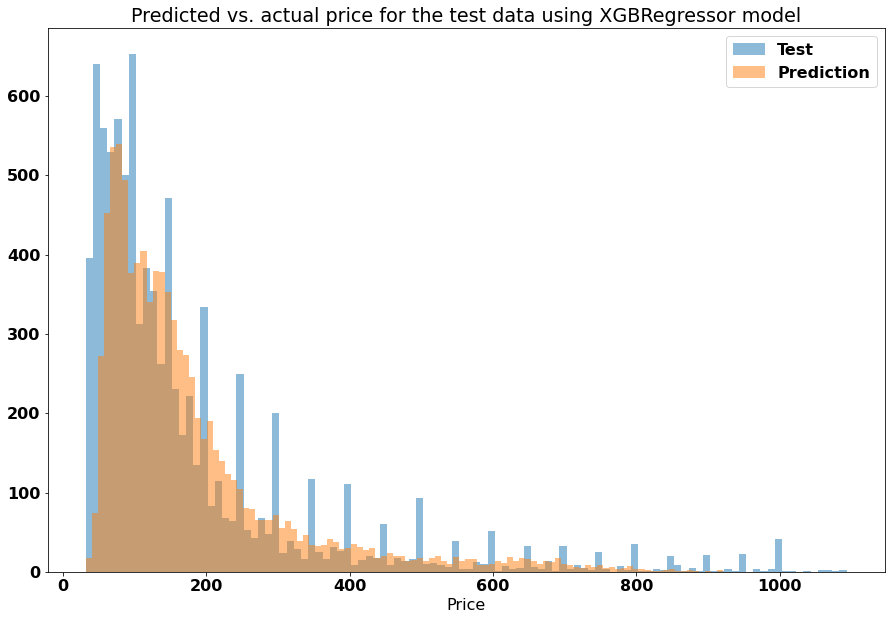

In [34]:
plt.figure(figsize=(15, 10))
plt.hist(y_test, bins=int((listings['price'].max() - listings['price'].min())/10), alpha=0.5)
plt.hist(best_model.predict(X_test), bins=int((listings['price'].max() - listings['price'].min())/10), alpha=0.5)
plt.legend(['Test', 'Prediction'])
plt.xlabel('Price')
plt.title('Predicted vs. actual price for the test data using XGBRegressor model')
plt.savefig('xgboost_pred_test_hist.jpg', dpi=500)
plt.show()

In [35]:

from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#scale the data to avoid numerical issues
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:

def build_model(n_hidden=1, n_neurons=5):
    
    """
      the neural network used for regression. The model is used in a RandomizedSearchCV
      to find the best number of neurons as well as hidden layers
      Inputs: 
      n_hidden - number of hidden layers in the model
      n_neurons number of neurons in each layer
      
      Output 
      model - the neural network model
    """

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[X_train.shape[1]]))

    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_regularizer=l2()))

    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer='adam',  metrics=['mean_squared_error'])

    return model

In [11]:
nn_regressor = keras.wrappers.scikit_learn.KerasRegressor(build_model, batch_size=500)


params = {
 "n_hidden": [1,2,3,5,10],
 "n_neurons": [10,20,30,40,50,60,100,200,300],   
}

nn_rnd_search = RandomizedSearchCV(estimator=nn_regressor, 
                                   param_distributions=params,
                                   scoring='r2',
                                   n_iter=50,
                                   verbose=2)
model_rnd_cv = nn_rnd_search.fit(X_train, y_train, epochs=50, verbose=0)

print("Best parameters =", nn_rnd_search.best_params_)
print("Best score: ", nn_rnd_search.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


2021-11-11 10:29:28.175131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 10:29:28.629783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11491 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
2021-11-11 10:29:28.799465: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[CV] END ...........................n_hidden=1, n_neurons=10; total time=   4.0s
[CV] END ...........................n_hidden=1, n_neurons=10; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=10; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=10; total time=   2.8s
[CV] END ...........................n_hidden=1, n_neurons=10; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=20; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=20; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=20; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=20; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=20; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=30; total time=   2.6s
[CV] END ...........................n_hidden=1, n_neurons=30; total time=   2.6s
[CV] END ...................

[CV] END ...........................n_hidden=3, n_neurons=30; total time=   3.0s
[CV] END ...........................n_hidden=3, n_neurons=30; total time=   3.1s
[CV] END ...........................n_hidden=3, n_neurons=30; total time=   3.0s
[CV] END ...........................n_hidden=3, n_neurons=40; total time=   3.1s
[CV] END ...........................n_hidden=3, n_neurons=40; total time=   3.0s
[CV] END ...........................n_hidden=3, n_neurons=40; total time=   3.1s
[CV] END ...........................n_hidden=3, n_neurons=40; total time=   3.3s
[CV] END ...........................n_hidden=3, n_neurons=40; total time=   3.0s
[CV] END ...........................n_hidden=3, n_neurons=50; total time=   3.1s
[CV] END ...........................n_hidden=3, n_neurons=50; total time=   3.1s
[CV] END ...........................n_hidden=3, n_neurons=50; total time=   3.0s
[CV] END ...........................n_hidden=3, n_neurons=50; total time=   3.1s
[CV] END ...................

[CV] END ..........................n_hidden=10, n_neurons=50; total time=   4.4s
[CV] END ..........................n_hidden=10, n_neurons=60; total time=   4.6s
[CV] END ..........................n_hidden=10, n_neurons=60; total time=   4.5s
[CV] END ..........................n_hidden=10, n_neurons=60; total time=   4.4s
[CV] END ..........................n_hidden=10, n_neurons=60; total time=   4.7s
[CV] END ..........................n_hidden=10, n_neurons=60; total time=   4.4s
[CV] END .........................n_hidden=10, n_neurons=100; total time=   4.6s
[CV] END .........................n_hidden=10, n_neurons=100; total time=   4.6s
[CV] END .........................n_hidden=10, n_neurons=100; total time=   4.5s
[CV] END .........................n_hidden=10, n_neurons=100; total time=   4.5s
[CV] END .........................n_hidden=10, n_neurons=100; total time=   4.8s
[CV] END .........................n_hidden=10, n_neurons=200; total time=   4.9s
[CV] END ...................

In [37]:
# final_model = build_model(n_hidden=nn_rnd_search.best_params_['n_hidden'], n_neurons=nn_rnd_search.best_params_['n_neurons'])
final_model = build_model(n_hidden=2, n_neurons=40)
history = final_model.fit(X_train, y_train, epochs=10, verbose=0)

2021-11-12 10:41:30.574097: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-12 10:41:30.935118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4981 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
2021-11-12 10:41:31.355228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


r2score in test: 0.6319592017188206
RMSE in test: 104.7319970579864


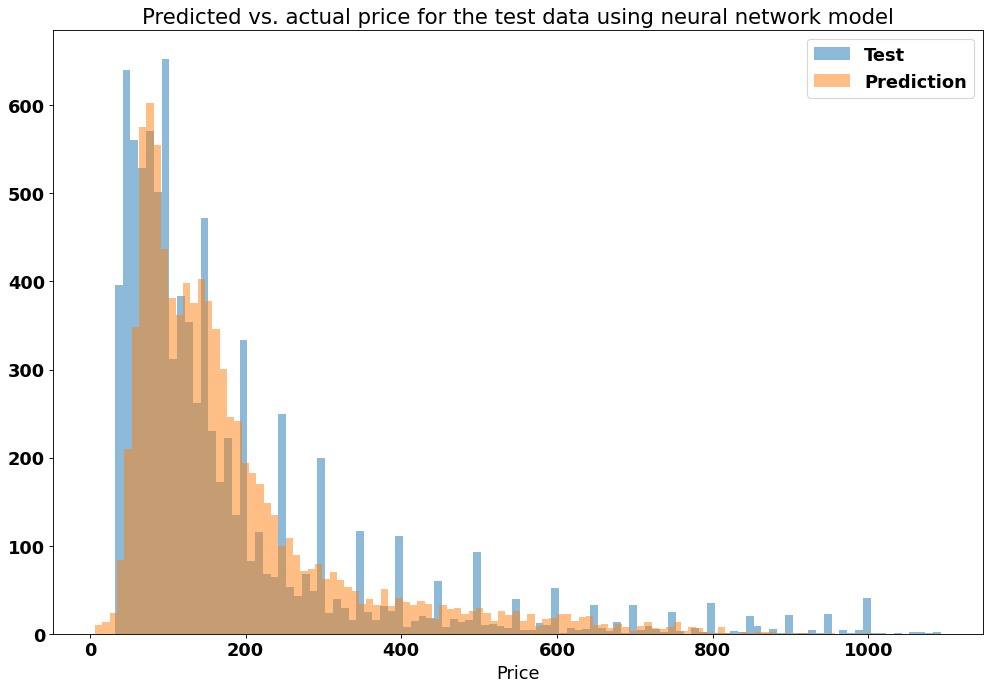

In [38]:
y_pred = final_model.predict(X_test)
r2_scores_test = r2_score(y_test, y_pred)
print("r2score in test:", r2_scores_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE in test:", rmse_test)
plt.figure(figsize=(15, 10), dpi=80)
plt.hist(y_test, bins=int((listings['price'].max() - listings['price'].min())/10), alpha=0.5)
plt.hist(y_pred, bins=int((listings['price'].max() - listings['price'].min())/10), alpha=0.5)
plt.legend(['Test', 'Prediction'])
plt.xlabel('Price')
plt.title('Predicted vs. actual price for the test data using neural network model')
plt.savefig('nn_pred_test_hist.jpg', dpi=500)
plt.show()